# David Fleming
# ASTR 597, Prof. Juric
# March 5th, 2016
# HW 2

In [1]:
%matplotlib inline

from __future__ import division, print_function

import matplotlib.pyplot as plt
import os
import numpy as np
from astropy.table import Table

#Typical plot parameters that make for pretty plots
plt.rcParams['figure.figsize'] = (10,8)
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=20, usetex=True)

plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rcParams['font.size'] = 20.0

# Magneto Settings
While working on magneto, reign in LSD.

In [2]:
os.environ['NWORKERS'] = '8'
os.environ['LSD_CACHEDIR'] = '/astro/users/dflemin3/tempdir'
os.environ['LSD_TEMPDIR'] = '/astro/users/dflemin3/tempdir'
os.environ['LSD_DB'] = '/astro/apps6/opt/lsddb'

# 1) Write a query (either SQL or for LSD) to select stars satisfying the g−r<0.4 color selection criterion (see Section 2 of Belokurov et al. 2006). You're free to either run this query against the CasJobs SDSS database, or the LSD copy of the database.

---

# Use LSD local sdss database, see its description.

In [3]:
! lsd-admin desc table sdss

Path:          /astro/apps6/opt/lsddb/sdss
Partitioning:  level=6
(t0, dt):      54335.000000, 1.000000 
Rows:          278674212
Columns:       33
Primary key:   sdss_id
Spatial keys:  (ra, dec)
Aliases:       []
Column groups: ['main', 'photometry', 'survey']
-------------------------------
Column group 'main':
              Column       Type
-------------------------------
             sdss_id         u8
                  ra         f8
                 dec         f8
                   l         f8
                   b         f8
                type         i4
               flags         i4
              flags2         i4
      resolve_status         i2
-------------------------------
-------------------------------
Column group 'photometry':
              Column       Type
-------------------------------
                   u         f4
                uErr         f4
                uExt         f4
              uCalib         i2
                   g         f4
                gE

# Create database object.

In [4]:
from lsd import DB
db = DB(os.environ['LSD_DB'])

# Query for correct stars according to Belokurov et al. 2006.
For the query, make sure we're just selecting stars and not galaxies with the correct color cut.  To do this, ensure that the sdss type corresponds to the type for stars, 6.

In [5]:
rows = db.query('select sdss_id, g, r, ra, dec from sdss where (g-r < 0.4) & (type == 6)').fetch()

 [1606 el.]WARNING:lsd.pool2:Error contacting lsd-manager. Cannot coordinate resource usage with others, using 8 cores.
:::::::::::::::WARNING:lsd.pool2:Error contacting lsd-manager. Cannot coordinate resource usage with others, using 8 cores.
:::::>  40.91 sec


# Convert to astropy Table for easier processing.

In [6]:
field = Table(rows.as_ndarray())

# 2) Write Python code to divide the stars into the three r-band magnitude bins (see the paper and/or the figure caption for magnitude bin specification), and bin them into 0.5 deg x 0.5 deg pixels. You may find numpy.histogram2d helpful.

---

### Bin the stars into 3 r magnitude bins according to Belokurov et al. 2006:

>Blue for the most nearby stars with r band magnitudes from 20.0-20.66, green for stars with 20.66-21.33, and red for the most distant stars with 21.33-22.0.

In [7]:
# Define masks to partition field via r magnitude cut
mask_blue = (field['r'] > 20.0) & (field['r'] <= 20.66)
mask_green = (field['r'] > 20.66) & (field['r'] <= 21.33)
mask_red = (field['r'] > 21.33) & (field['r'] <= 22.0)

# Define bins to paritions physical sky in 0.5 degree^2 bins
dec_bins = np.linspace(-5,60,int((60+5)/0.5))
ra_bins = np.linspace(110,230,int((230-110)/0.5))

In [8]:
# Create histograms (edges are the same, so no need to overwrite)
# Don't forget to fix to per 0.5 square degrees
H_blue = np.histogram2d(field['ra'][mask_blue],field['dec'][mask_blue],bins=[ra_bins,dec_bins])[0]*4
H_green = np.histogram2d(field['ra'][mask_green],field['dec'][mask_green],bins=[ra_bins,dec_bins])[0]*4
H_red = np.histogram2d(field['ra'][mask_red],field['dec'][mask_red],bins=[ra_bins,dec_bins])[0]*4

# 3) Use matplotlib.imshow (or any other Python library of your choice) to create an RGB color composite equivalent of Figure 1. from the paper (see the figure caption for details)

---

For imshow, if we pass it a m x n x 3 array, it will interpret it as a RGB image with array[m,n,:] = (r,g,b) for coloring purposes.  For matplotlib to properly display the image, however, the r,g,b color values must be normalized to the range [0,1] with 0 corresponding to black and 1 white.  For normalization, use the stellar densities ranges given by Belokurov 2006:
>The displayed density ranges are 102–330 (red), 107–304 (green), and 98–267 (blue)

In [9]:
# Reshape and renomalize
H_blue[H_blue > 267.] = 267.
H_blue[H_blue < 98.] = 98.
H_blue = (H_blue-98.0)/(267.0-98.0)

H_green[H_green > 304.] = 304.
H_green[H_green < 107.] = 107.
H_green = (H_green-107.0)/(304.-107.)

H_red[H_red > 330.] = 330.
H_red[H_red < 102.] = 102.
H_red = (H_red-102.0)/(330.0-102.0)

# Combine the histograms into an array with the proper shape for RGB viewing using imshow.

In [10]:
res = np.array([H_red,H_green,H_blue]) #(3 x m x n)

# Plot the Field of Streams! 
If you plot it, they will cite.

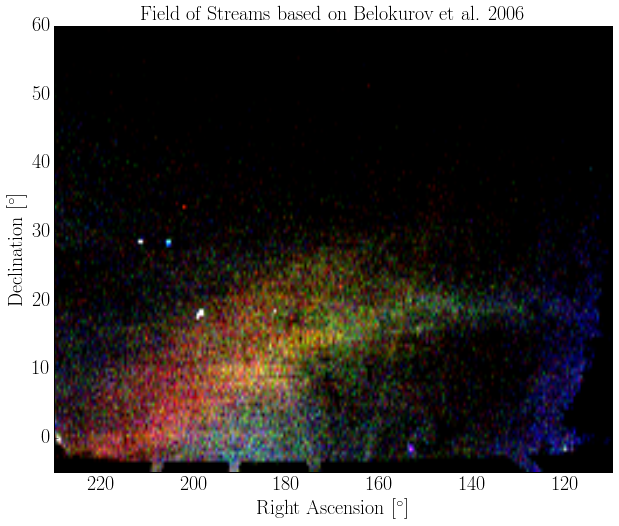

In [11]:
fig, ax = plt.subplots(figsize=(10,8))

extent = [ra_bins.min(),ra_bins.max(),dec_bins.min(),dec_bins.max()]
ax.imshow(res.T,origin='lower',aspect='auto',extent=extent)

# Format plot
ax.set_ylim(dec_bins.min(),dec_bins.max())
ax.set_xlim(ra_bins.min(),ra_bins.max())
ax.invert_xaxis()

ax.set_xlabel(r"Right Ascension [$^{\circ}$]")
ax.set_ylabel(r"Declination [$^{\circ}$]")
ax.set_title(r"Field of Streams based on Belokurov et al. 2006")